# RNN을 활용한 BaselineModel

original_text, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=5

In [135]:
# GPU로 Tesla T4가 준비돼있습니다.
!nvidia-smi

Wed Jun 26 13:52:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |    731MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [136]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json

## 1. 데이터 가져오기

In [137]:
train1_data_path ="~/aiffel/dktc/data/train.csv"
data1 = pd.read_csv(train1_data_path)

train_data_path ="augmented_train-Copy1.csv"
data = pd.read_csv(train_data_path)
data.head()

,idx,class,conversation
0,0.0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1.0,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2.0,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3.0,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4.0,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [138]:
data.shape

(27650, 3)

## 2. 데이터 전처리

### 2-1)결측치, 중복데이터 확인

In [139]:
print(data.isna().sum())

idx             23700
class               0
conversation        0
dtype: int64


In [140]:
#중복인 행 확인
data['duplicates'] = data.duplicated(['conversation'])
data[data['duplicates'] == True]

data1['duplicates'] = data1.duplicated(['conversation'])
data1[data1['duplicates'] == True]

,idx,class,conversation,duplicates
392,392,기타 괴롭힘 대화,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...,True
523,523,직장 내 괴롭힘 대화,과장님. 저 이번에 휴가 좀 갔다와도 되겠습니까.?\n휴가? 왜??\n좀 쉬다가 오...,True
789,789,기타 괴롭힘 대화,야 얘 이 쪽 손가락 세 개밖에 없다\n엥 손가락이 세개밖에 없을 수가 있어?\n봐...,True
824,824,기타 괴롭힘 대화,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...,True
869,869,직장 내 괴롭힘 대화,지현씨 나 소개팅 좀 시켜줘봐\n네? 저 주변에 아는 사람이 없어서요\n아 상사라 ...,True
...,...,...,...,...
3797,3797,기타 괴롭힘 대화,너 이번 방학 때 쌍꺼풀 수술 하고왔지?\n아닌데?\n아니긴 뭐가 아니야. 눈이 이...,True
3798,3798,기타 괴롭힘 대화,안녕하세요 지금 먹방 촬영중인데 촬영가능할까요?\n안돼요\n한번만 안될까요?\n안돼...,True
3855,3855,기타 괴롭힘 대화,그 소문 진짜야? 너가 다른 애들 뒷담화하고 다녔다며?\n응? 나 그런 적 없는데?...,True
3874,3874,기타 괴롭힘 대화,야 니 왤캐 못생겼냐?\n뭐라그랬냐?\n으 나 보고 말하지마 니 얼굴보면 토나올거 ...,True


In [141]:
#중복제거
data = data.drop_duplicates(['conversation'])
data1 = data1.drop_duplicates(['conversation'])

In [142]:
#conversation과 class만 남김
data = data[['conversation','class']]
data.head()

data1 = data1[['conversation','class']]

In [143]:
data1.shape

(3846, 2)

In [144]:
data.shape

(21307, 2)

In [145]:
data[0:20]

,conversation,class
0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,협박 대화
1,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,협박 대화
2,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,기타 괴롭힘 대화
3,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,갈취 대화
4,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,갈취 대화
5,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로.\n가나다 음식점이요.?\n응....,직장 내 괴롭힘 대화
6,35번 손님 아이스커피 두잔나왔습니다\n아이스커피? \n네 맛있게드세요\n저기요 아...,기타 괴롭힘 대화
7,경비아저씨 내차에 경고장 붙였어요?\n내가 여기 몇년째 사는데 아직도 내차인줄 모르...,기타 괴롭힘 대화
8,이거 할인 된다면서요\n 확인해보겠습니다\n 아까 저 시람은 할인 해주던데\n 네 ...,기타 괴롭힘 대화
9,자네 세금계산서 보내준 거 메일이랑 수치가 다르던데?\n그게.\n얼마나 해먹었어? ...,갈취 대화


In [146]:
data[3846:3866]

,conversation,class
3950,지금 너 스스로를 죽여달라고 애원하는 못하겠습니다. 아닙니다. 죄송합니다.\n 죽을...,협박 대화
3951,지금 너 스스로를 진 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 진...,협박 대화
3952,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,협박 대화
3953,너 스스로를 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 거면 혼자 죽지 우리까...,협박 대화
3954,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,협박 대화
3956,길동경찰서입니다.\n9시 40분 한번만 다 설치할거다.\n네?\n똑바로 들어 마트에...,협박 대화
3962,너 되게 귀여운거 놀리는거 나보다 작은 남자는 첨봤어.\n그만해. 니들 알지? 재미...,기타 괴롭힘 대화
3963,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,기타 괴롭힘 대화
3964,너 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 재미없어.\n지영아...,기타 괴롭힘 대화
3966,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,기타 괴롭힘 대화


### 2-2)레이블인코딩

In [147]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

data['class'] = encoder.transform(data['class'])

corpus = data["conversation"]
data.head()



,conversation,class
0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,3
1,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,3
2,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,1
3,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,0
4,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0


In [148]:
data1.head()

,conversation,class
0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,협박 대화
1,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,협박 대화
2,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,기타 괴롭힘 대화
3,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,갈취 대화
4,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,갈취 대화


In [149]:
encoder1 = LabelEncoder()
encoder1.fit(CLASS_NAMES)
data1['class'] = encoder1.transform(data1['class'])

corpus1 = data1["conversation"]

### 2-3)토크나이저 및 단어사전 생성

In [150]:
def tokenize(corpus):
    #토크나이저 객체생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=1000, 
        filters=' ',
        oov_token="<unk>")
    
    tokenizer.fit_on_texts(corpus) #corpus 기준으로 단어 사전 생성
    tensor = tokenizer.texts_to_sequences(corpus) #정수시퀀스
    
    #시퀀스패딩
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                           maxlen=20) #최대길이
    print(tensor,tokenizer)
    return tensor, tokenizer

#데이터셋에서 토큰화 및 패딩작업 결과를 저장
tensor, tokenizer = tokenize(corpus)
tensor1, tokenizer1 = tokenize(corpus1)

[[  1 204   1 ...   1  43   1]
 [  1   1   1 ...   1   1 410]
 [  1  96   1 ...   1 137   1]
 ...
 [310   1   1 ... 162 121   1]
 [  1   1   1 ... 162 121   1]
 [  1   1   1 ...   1 121   1]] <keras_preprocessing.text.Tokenizer object at 0x7ee81628d580>
[[  1 210   1 ...   1  42   1]
 [  1   1   1 ...   1   1 401]
 [  1  97   1 ...   1 136   1]
 ...
 [495   3 110 ...  27   1   1]
 [  1   1 151 ... 348   1   1]
 [  1   1   1 ... 159 113   1]] <keras_preprocessing.text.Tokenizer object at 0x7ee875e7a790>


In [151]:
data.shape

(21307, 2)

### 2-4)데이터 분할

In [152]:
X_train = tensor[:17000]
y_train = data['class'][:17000]
X_val = tensor[17000:21307]
y_val = data['class'][17000:21307]

In [153]:
testx = tensor1
testy = data1['class']

# 3. 모델생성 및 훈련

- baseline 모델은 바닐라 RNN 모델로 설정
- LSTM, GRU, 1D COV 등 모델 및 pretrained bert 등을 활용예정

## 3-1) 모델 구성

In [156]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN,Dropout, Dense,Conv1D,GlobalMaxPooling1D


vocab_size = 1000  # 어휘 사전의 크기
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수


model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_length=None))
model.add(Conv1D(256, 3, activation='relu')) 
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 20)          20000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 256)         15616     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 52,324
Trainable params: 52,324
Non-trainable params: 0
__________________________________________________

In [157]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [158]:
#모델 compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [159]:
#콜백함수
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료 여부 판단
    patience=10,         # 검증 손실이 개선되지 않는 epoch를 5회까지 허용
    restore_best_weights=True  # 가장 좋은 검증 손실을 낸 모델의 가중치 복원
)

## 3-2) 모델 학습

In [160]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
532/532 [==============================] - 31s 5ms/step - loss: 0.9584 - accuracy: 0.5946 - val_loss: 0.8795 - val_accuracy: 0.6582
Epoch 2/100
532/532 [==============================] - 2s 4ms/step - loss: 0.4956 - accuracy: 0.8192 - val_loss: 0.8908 - val_accuracy: 0.6840
Epoch 3/100
532/532 [==============================] - 2s 4ms/step - loss: 0.3584 - accuracy: 0.8742 - val_loss: 0.8454 - val_accuracy: 0.7147
Epoch 4/100
532/532 [==============================] - 2s 4ms/step - loss: 0.2745 - accuracy: 0.9091 - val_loss: 0.8159 - val_accuracy: 0.7420
Epoch 5/100
532/532 [==============================] - 2s 4ms/step - loss: 0.2188 - accuracy: 0.9276 - val_loss: 0.7657 - val_accuracy: 0.7643
Epoch 6/100
532/532 [==============================] - 2s 4ms/step - loss: 0.1752 - accuracy: 0.9438 - val_loss: 0.6674 - val_accuracy: 0.7959
Epoch 7/100
532/532 [==============================] - 2s 4ms/step - loss: 0.1416 - accuracy: 0.9539 - val_loss: 0.6720 - val_accuracy: 0.816

## 3-3) 학습과정 시각화

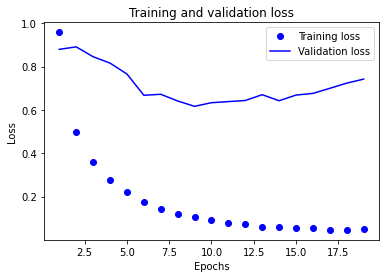

In [161]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

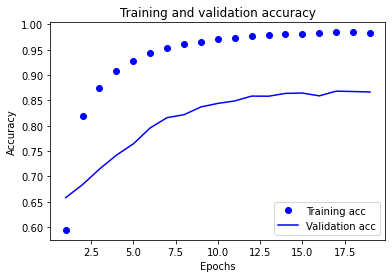

In [162]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3-4) 성능 확인

In [163]:
results = model.evaluate(testx,testy, verbose=2)

121/121 - 0s - loss: 5.9561 - accuracy: 0.2891


In [164]:
loss = results[0]
accuracy = results[1] 

In [165]:
# 예측
y_pred = model.predict(testx)
y_pred_classes = y_pred.argmax(axis=-1)  # 예측 확률 값을 클래스 레이블로 변환

In [166]:
print(y_pred_classes)

[3 3 1 ... 3 2 1]


In [167]:
from sklearn.metrics import classification_report

report_dict = classification_report(testy, y_pred_classes)

print(report_dict)


              precision    recall  f1-score   support

           0       0.27      0.25      0.26       973
           1       0.32      0.30      0.31      1011
           2       0.31      0.36      0.33       970
           3       0.25      0.24      0.25       892

    accuracy                           0.29      3846
   macro avg       0.29      0.29      0.29      3846
weighted avg       0.29      0.29      0.29      3846



In [168]:
print(report_dict)

              precision    recall  f1-score   support

           0       0.27      0.25      0.26       973
           1       0.32      0.30      0.31      1011
           2       0.31      0.36      0.33       970
           3       0.25      0.24      0.25       892

    accuracy                           0.29      3846
   macro avg       0.29      0.29      0.29      3846
weighted avg       0.29      0.29      0.29      3846



In [169]:
report_dict = classification_report(testy, y_pred_classes, output_dict=True)

# 필요한 값 추출 및 출력
precision = report_dict['weighted avg']['precision']
recall = report_dict['weighted avg']['recall']
f1 = report_dict['weighted avg']['f1-score']

print("weighted avg precision :", precision)
print("weighted avg recall :", recall)
print("weighted avg f1-score :", f1)

weighted avg precision : 0.2881556431746872
weighted avg recall : 0.2891315652626105
weighted avg f1-score : 0.28813872670324575


In [170]:
df = pd.DataFrame(report_dict)

In [171]:
df

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.270179,0.317805,0.314260,0.245772,0.289132,0.287004,0.288156
recall,0.247688,0.303660,0.356701,0.244395,0.289132,0.288111,0.289132
f1-score,0.258445,0.310572,0.334138,0.245082,0.289132,0.287059,0.288139
support,973.000000,1011.000000,970.000000,892.000000,0.289132,3846.000000,3846.000000
